In [2]:
import os
from tqdm import tqdm
from huggingface_hub import login
import torch
import torch.nn as nn
import math
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px
from jaxtyping import Float
from functools import partial
import transformer_lens.utils as utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
from sklearn.tree import _tree

/Users/anaiskillian/anaconda3/envs/ml_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("access.tok", "r") as file:
    access_token = file.read().strip()
    login(token=access_token)

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: mps


In [4]:
from datasets import load_dataset  
import transformer_lens
from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer

torch.set_grad_enabled(False)

In [5]:
# load gpt-2-small (for testing)
model = HookedSAETransformer.from_pretrained("gpt2-small", device=device)

# load sae on res stream of gpt-2-small, plus cfg and sparsity val (for testing)
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = "blocks.7.hook_resid_pre",
    device = device
)

Loaded pretrained model gpt2-small into HookedTransformer


/Users/anaiskillian/anaconda3/envs/ml_env/lib/python3.11/site-packages/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [6]:
df = pd.read_csv('dataset/harmful_strings.csv')

columns_as_arrays = [df[col].values for col in df.columns]

array_dict = {col: df[col].values for col in df.columns}

negative_set = columns_as_arrays[0]
negative_set = negative_set[:100]
print(len(negative_set))

100


In [7]:
positive = pd.read_json('dataset/alpaca_data.json')

positive_set = positive['output'].values
positive_set = positive_set[:100]
print(len(positive_set))

100


In [8]:
sae.use_error_term

top_neurons_neg = {}
top_neurons_pos = {}

for example in negative_set:
    _, cache = model.run_with_cache_with_saes(example, saes=[sae])

    # get top 15 firing sae neurons
    vals, inds = torch.topk(cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :], 15)

    for datapoint in zip(inds, vals):
        if datapoint[0] in top_neurons_neg:
            top_neurons_neg[datapoint[0]].append(datapoint[1])
        else:
            top_neurons_neg[datapoint[0]] = [datapoint[1]]
    

for example in positive_set:
    _, cache = model.run_with_cache_with_saes(example, saes=[sae])

    # get top 15 firing sae neurons
    vals, inds = torch.topk(cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :], 15)

    for datapoint in zip(inds, vals):
        if datapoint[0] in top_neurons_pos:
            top_neurons_pos[datapoint[0]].append(datapoint[1])
        else:
            top_neurons_pos[datapoint[0]] = [datapoint[1]]

In [9]:
# train classifier on sae activations
activations_list = []
labels_list = []

# 0 = negative, 1 = positive
for example_txt in negative_set:
    _, cache = model.run_with_cache_with_saes(example_txt, saes=[sae])
    activations = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy()
    print(activations.shape)

    activations_list.append(activations)
    labels_list.append(0)

for example_txt in positive_set:
    _, cache = model.run_with_cache_with_saes(example_txt, saes=[sae])
    activations = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy()

    activations_list.append(activations)
    labels_list.append(1)   

# data
X = np.array(activations_list)
y = np.array(labels_list)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale activation features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, solver='lbfgs') 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
(24576,)
Test Accuracy: 0.9500


In [10]:
# train classifier on base activations
activations_list = []
labels_list = []

# 0 = negative, 1 = positive
for example_txt in negative_set:
    _, cache = model.run_with_cache(example_txt)
    res_stream = cache.decompose_resid(layer=8, return_labels=False, mode='attn', incl_embeds=False, pos_slice=slice(0, -1))
    seven_out = res_stream[-1, 0, -1, :].cpu().numpy()  # layer batch pos d_model
    print(seven_out.shape)

    activations_list.append(seven_out)
    labels_list.append(0)

for example_txt in positive_set:
    _, cache = model.run_with_cache(example_txt)
    res_stream = cache.decompose_resid(layer=8, return_labels=False, mode='attn', incl_embeds=False, pos_slice=slice(0, -1))
    seven_out = res_stream[-1, 0, -1, :].cpu().numpy()  # layer batch pos d_model

    activations_list.append(seven_out)
    labels_list.append(1)

# data and split
X = np.array(activations_list)
y = np.array(labels_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train classifier
clf = LogisticRegression(max_iter=1000, solver='lbfgs') 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
(768,)
Test Accuracy: 1.0000


In [11]:
# reject sample if activation at any of top N neurons is above threshold T
THRESHOLD = 2
NEURONS_TO_CONSIDER = 10

top_neurons_neg_mean = [(8023, 41), (6056, 23), (3261, 23), (6136, 21), (21916, 18), (11946, 17), (19967, 16), (17723, 15), (16804, 15), (3087, 14), (13368, 14), (5481, 12), (14325, 12), (22930, 11), (8011, 11), (1460, 10), (14179, 10), (14867, 10), (8244, 10), (20483, 9), (22309, 9), (5298, 8), (17151, 8), (15637, 8), (19092, 8), (14687, 8), (19351, 8), (24391, 7), (20960, 7), (720, 7), (16672, 7), (3540, 7), (7186, 7), (12163, 7), (2226, 7), (13306, 7), (6647, 7), (20936, 7), (6670, 6), (3045, 6), (9307, 6), (133, 6), (22721, 6), (21485, 6), (513, 6), (17732, 6), (1911, 6), (2831, 6), (11712, 6), (11213, 6), (15557, 6), (3092, 6), (21040, 6), (2284, 6), (20658, 6), (16694, 6), (22822, 6), (2312, 5), (17282, 5), (22894, 5), (15423, 5), (6302, 5), (4808, 5), (303, 5), (2908, 5), (20511, 5), (5834, 5), (307, 5), (14490, 5), (16038, 5), (4478, 5), (14743, 5), (6526, 5), (4495, 5), (4415, 5), (6524, 5), (7323, 5), (14633, 5), (3578, 5), (15102, 5), (14929, 5), (20157, 5), (22815, 5), (20572, 5), (13804, 5), (19045, 4), (127, 4), (3879, 4), (21309, 4), (20505, 4), (17228, 4), (16466, 4), (13702, 4), (3108, 4), (10072, 4), (17112, 4), (22881, 4), (18372, 4), (22414, 4), (12656, 4)]
top_neurons_pos_mean = [(2928, 43), (13638, 37), (14812, 37), (9749, 33), (23171, 32), (19991, 31), (3088, 30), (2382, 28), (5226, 27), (20364, 24), (2367, 23), (323, 23), (12588, 22), (23013, 22), (1724, 20), (23676, 20), (355, 19), (23595, 19), (22579, 18), (3290, 18), (10655, 18), (1432, 17), (501, 17), (18243, 17), (10680, 15), (15585, 14), (9976, 14), (19363, 13), (7274, 13), (11299, 12), (23163, 12), (20035, 12), (7046, 12), (23126, 12), (19711, 12), (6849, 12), (15617, 12), (1664, 11), (981, 11), (20365, 11), (19528, 11), (18539, 10), (14993, 10), (15106, 10), (10550, 10), (22595, 10), (24158, 10), (10110, 10), (18986, 10), (12940, 10), (20454, 10), (7085, 10), (11990, 10), (13726, 10), (8872, 9), (18607, 9), (386, 9), (21014, 9), (15955, 9), (3406, 9), (14719, 9), (4447, 9), (13758, 9), (6726, 8), (14024, 8), (10845, 8), (19908, 8), (17213, 8), (18626, 8), (2617, 8), (15580, 8), (11310, 8), (6979, 8), (506, 8), (8095, 8), (9680, 8), (24427, 7), (6610, 7), (14237, 7), (6584, 7), (1125, 7), (18881, 7), (4354, 7), (14390, 7), (13286, 7), (6213, 7), (12377, 7), (3805, 7), (3631, 7), (13505, 7), (22162, 6), (621, 6), (10947, 6), (2891, 6), (21286, 6), (13437, 6), (8715, 6), (13512, 6), (1644, 6), (14913, 6)]
neg_indicators = []

for entry in top_neurons_neg_mean:
    neg_indicators.append(entry[0])

print(neg_indicators)

# run an inference, if hits threshold on any of the neurons classify as bad
e = 0
neg_classifications = np.zeros(200)
for example in negative_set:
    _, cache = model.run_with_cache_with_saes(example, saes=[sae])

    # get data from indicator neurons
    val = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :]
    for critical_neuron_idx in neg_indicators:
        if (val[critical_neuron_idx] > THRESHOLD):
            neg_classifications[e] = 1
            break
    e += 1

pos_classifications = np.zeros(200)


e = 0
for example in positive_set:
    _, cache = model.run_with_cache_with_saes(example, saes=[sae])

    # get data from indicator neurons
    val = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :]
    for critical_neuron_idx in neg_indicators:
        if (val[critical_neuron_idx] > THRESHOLD):
            pos_classifications[e] = 1
            break
    e += 1

print(" RATS ! ", np.sum(neg_classifications) / 2)
print(" GENIUSES ! ", np.sum(pos_classifications) / 2)

[8023, 6056, 3261, 6136, 21916, 11946, 19967, 17723, 16804, 3087, 13368, 5481, 14325, 22930, 8011, 1460, 14179, 14867, 8244, 20483, 22309, 5298, 17151, 15637, 19092, 14687, 19351, 24391, 20960, 720, 16672, 3540, 7186, 12163, 2226, 13306, 6647, 20936, 6670, 3045, 9307, 133, 22721, 21485, 513, 17732, 1911, 2831, 11712, 11213, 15557, 3092, 21040, 2284, 20658, 16694, 22822, 2312, 17282, 22894, 15423, 6302, 4808, 303, 2908, 20511, 5834, 307, 14490, 16038, 4478, 14743, 6526, 4495, 4415, 6524, 7323, 14633, 3578, 15102, 14929, 20157, 22815, 20572, 13804, 19045, 127, 3879, 21309, 20505, 17228, 16466, 13702, 3108, 10072, 17112, 22881, 18372, 22414, 12656]
 RATS !  46.5
 GENIUSES !  1.5


Test Accuracy with Decision Tree: 0.8000
Decision thresholds for neurons:

Neuron_480 <= 0.0077
Neuron_632 <= 1.7401
Neuron_756 <= -1.2671
Neuron_438 <= -0.3495
Neuron_40 <= -0.0326
Neuron_699 <= -0.1152
Neuron_535 <= 1.9415
Neuron_615 <= -0.3845
Neuron_582 <= 0.5291
Neuron_398 <= 0.7158
Neuron_466 <= 1.0291
Neuron_389 <= -0.2480


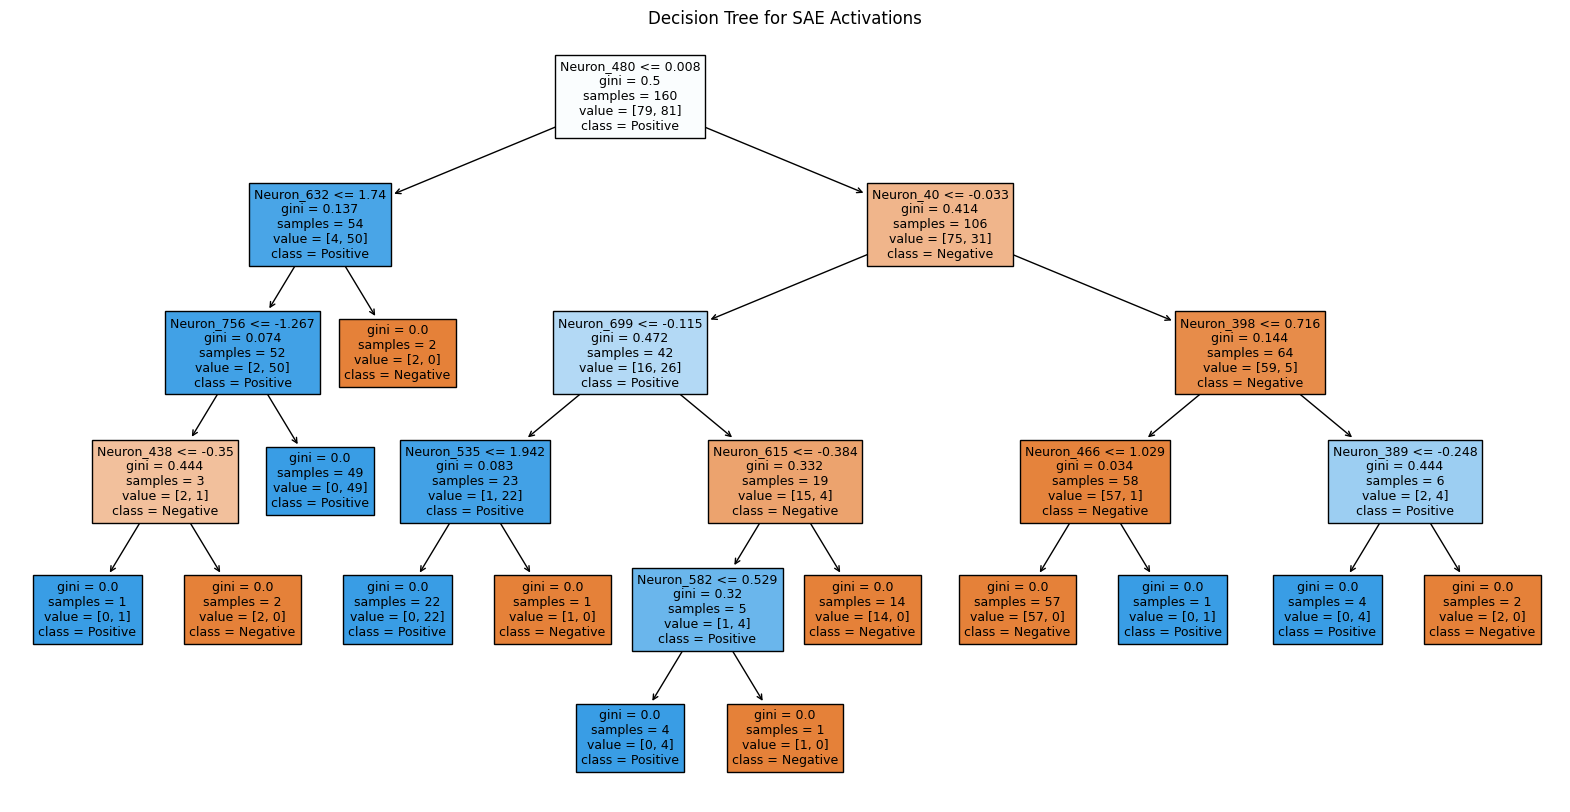

Top neurons and their significance in decision making:
         Neuron  Importance
480  Neuron_480    0.358958
40    Neuron_40    0.185525
699  Neuron_699    0.144781
615  Neuron_615    0.058957
398  Neuron_398    0.057341
632  Neuron_632    0.044523
389  Neuron_389    0.033339
756  Neuron_756    0.031415
466  Neuron_466    0.024573
535  Neuron_535    0.023917
582  Neuron_582    0.020003
438  Neuron_438    0.016669
Top neurons and their significance in decision making:

Neuron_480 Importance: 0.3590
Neuron_632 Importance: 0.0445
Neuron_756 Importance: 0.0314
Neuron_438 Importance: 0.0167
Neuron_40 Importance: 0.1855
Neuron_699 Importance: 0.1448
Neuron_535 Importance: 0.0239
Neuron_615 Importance: 0.0590
Neuron_582 Importance: 0.0200
Neuron_398 Importance: 0.0573
Neuron_466 Importance: 0.0246
Neuron_389 Importance: 0.0333


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree

# replace Logistic Regression with Decision Tree for classification
# any number can be used as the random seed (42 is a popular choice)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy with Decision Tree: {accuracy:.4f}')

def print_decision_thresholds(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("Decision thresholds for neurons:\n")
    for i in range(tree_.node_count):
        if tree_.feature[i] != _tree.TREE_UNDEFINED:
            print(f"{feature_name[i]} <= {tree_.threshold[i]:.4f}")

# feature names based on neuron index
feature_names = [f'Neuron_{i}' for i in range(X_train.shape[1])]

# decision thresholds
print_decision_thresholds(clf, feature_names)

# visualizing decision boundaries
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=[f'Neuron_{i}' for i in range(X_train.shape[1])], class_names=['Negative', 'Positive'])
plt.title("Decision Tree for SAE Activations")
plt.show()

# Feature importance
importance = clf.feature_importances_
importance_df = pd.DataFrame({"Neuron": [f'Neuron_{i}' for i in range(X_train.shape[1])], "Importance": importance})
importance_df = importance_df[importance_df["Importance"] > 0].sort_values(by="Importance", ascending=False)

print("Top neurons and their significance in decision making:")
print(importance_df)

def print_importance(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("Top neurons and their significance in decision making:\n")
    for i in range(tree_.node_count):
        if tree_.feature[i] != _tree.TREE_UNDEFINED:
            feature_index = tree_.feature[i]
            neuron_name = f"Neuron_{feature_index}"
            if neuron_name in importance_df["Neuron"].values:
                print(f"{neuron_name} Importance: {importance[feature_index]:.4f}")

print_importance(clf, feature_names)
